# <span style="color:darkred">Resubmission Updates Made </span>

<font color='darkred' size=3>
Group 5 -
Blake, Neddy, Rohit
    
    
> Please note, all updates from the initial submission have been marked in this red font with block quotes. Additionally the resubmission updates are summarized below.  
> - **Data Meaing Type** Added some additonal explanation to the data dictionary   
> - **Data Quality** Moved missing data chart into section. Added additional explanation. Added outlier charts and explanation.   
> - **Simple Statistics** added detailed analysis of boolean, float, and object data types. 
> - **Visualize Attributes** correlation plot: added detailed analysis, added 2nd correlation plot to include p-values. Removed superfluous charts.
> - **Explore Joint Attributes** added more detailed analysis. Removed superfluous charts.
> - **Explore Attributes and Class** added more detailed analysis. Add additional cool_count strip plot as well as a boxplot for review_word_count.  

    
</font>


 ![feedback.png](feedback.png)

In [1]:
! pip3 install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as ny
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import os 
from pandasql import sqldf
from pandas import json_normalize

# Reading, Flattening, Merging Yelp Research Data sets
## Source: https://www.kaggle.com/yelp-dataset/yelp-dataset?select=Dataset_Agreement.pdf

In [3]:
import os

#Set location to store data files
file_path=os.path.expanduser('~')+'/Documents/yelp_datasets/'

#make sure you've added your API token at ~/.kaggle/kaggle.json 

#follow this guide 
#https://medium.com/analytics-vidhya/fetch-data-from-kaggle-with-python-9154a4c610e3
#!chmod 600 /home/$USER/.kaggle/kaggle.json

if(os.path.isdir(file_path)):
    print("Files already downloaded.")
else: 
    from kaggle.api.kaggle_api_extended import KaggleApi
    kapi = KaggleApi()
    kapi.authenticate()

    os.makedirs(file_path,exist_ok=True)
    kapi.dataset_download_files(dataset='yelp-dataset/yelp-dataset', path=file_path)
    from zipfile import ZipFile
    zf = ZipFile(file_path + 'yelp-dataset.zip')

    zf.extractall(file_path) #save files in selected folder
    zf.close()

Files already downloaded.


## Business core dataset

In [4]:
df_business = pd.read_json('~/Documents/yelp_datasets/yelp_academic_dataset_business.json',lines=True)
df_business.shape

(209393, 14)

## Flatten Attributes column

In [5]:
df_battributes = df_business['attributes'].apply(pd.Series)

## User checkins

In [6]:
df_checkin = pd.read_json('~/Documents/yelp_datasets/yelp_academic_dataset_checkin.json',lines=True)

## Aggregating all checkins

In [7]:
df_checkin['checkin_count'] = df_checkin['date'].str.count(',') + 1

## Reading file for tips (thank you notes)

In [8]:
df_tip = pd.read_json('~/Documents/yelp_datasets/yelp_academic_dataset_tip.json',lines=True)

## Reading the Reviews Json
### Since the Json is very big (6 gb), I have split it into multiple files are then read it to same memory utilization
#### Command: split -l 500000 yelp_academic_dataset_review.json review
#### I also dropped the actual review column which probably is taking bulk of the space

In [9]:
import socket

is_rohit=socket.gethostname()=='Rohits-MacBook-Pro.local'
is_blake=socket.gethostname()=='BJH-ML-machine'

if(is_rohit):
    df_review = pd.read_json('~/Documents/yelp_datasets/reviewaa',lines=True)
else: 
    df_review = pd.read_json('~/Documents/yelp_datasets/yelp_academic_dataset_review.json',lines=True)

In [10]:
df_review['review_word_count'] = df_review['text'].str.count(' ')

In [11]:
file_names = ['reviewac','reviewae','reviewag','reviewai','reviewak','reviewam','reviewao','reviewaq','reviewab','reviewad','reviewaf','reviewah','reviewaj','reviewal','reviewan','reviewap']

In [12]:
df_review = df_review.drop(columns = ['text'])

In [13]:
if(is_rohit):
    for file in file_names:
        df_temp = pd.read_json(f'~/Documents/yelp_datasets/{file}',lines=True)
        df_temp['review_word_count'] = df_temp['text'].str.count(' ') + 1
        df_temp.drop(columns = ['text'])
        df_review = pd.concat([df_review,df_temp])

In [14]:
review_agg_filepath=os.path.expanduser('~')+'/Documents/yelp_datasets/review_agg.csv'
if(os.path.isfile(review_agg_filepath)):
    print("Loading existing flattened csv file.")
    df_review_agg = pd.read_csv(review_agg_filepath)
else:
    df_review_agg = sqldf("""
    select  business_id, 
            sum(case when useful > 0 then 1 else 0 end) as useful_count,
            sum(case when funny > 0 then 1 else 0 end) as funny_count,
            sum(case when cool > 0 then 1 else 0 end) as cool_count,
            avg(review_word_count) review_word_count 
    from df_review group by business_id""")
    df_review_agg.to_csv(review_agg_filepath)

Loading existing flattened csv file.


### Exploding Categories (But keeping it as a separate df since it has a many to many relationship with business)

In [15]:
df_category = df_business[['business_id','categories']]

In [16]:
df_category = df_category.assign(categories=df_category['categories'].str.split(',')).explode('categories')

### Flatten the categories (this takes some time to run) 

In [17]:
#Since this is long running, store the flattened categories as csv and import flatfile on subsequent runs

business_categories_filepath=os.path.expanduser('~')+'/Documents/yelp_datasets/business_categories.csv'
categories_filepath=os.path.expanduser('~')+'/Documents/yelp_datasets/categories.csv'


if(os.path.isfile(business_categories_filepath) & os.path.isfile(categories_filepath)):
    print("Loading existing flattened csv file.")
    df_business_categories = pd.read_csv(business_categories_filepath)
    df_categories = pd.read_csv(categories_filepath)
else: 
    print("Flattening business categories into dataframe. This will take a while.")
    df_categories=df_business['categories'].str.get_dummies(sep=",")
    #Just keep the top 10 most used categories because there are 2000+
    keep_columns=df_categories.sum().sort_values(ascending=False).index[0:10]
    df_business_categories=pd.concat([df_business.drop('categories', 1), 
                                  df_categories[keep_columns]], 
                                 1)
    df_business_categories.to_csv(business_categories_filepath)
    df_categories.to_csv(categories_filepath)

Loading existing flattened csv file.


## Merging Business Attributes, Checkin, Tip, Review_agg, Parking Info datasets

### Business plus Attributes

In [18]:
df_business_final = pd.merge(df_business_categories,df_battributes,how='left',left_index=True, right_index=True)

### Business plus Checkin

In [19]:
df_business_final = pd.merge(df_business_final,df_checkin[['business_id','checkin_count']],how='left',on='business_id')

### Business plus Tips

In [20]:
df_business_final = pd.merge(df_business_final,df_tip.groupby(by="business_id").agg('count').filter(regex = 'business_id|text'),how='left',on='business_id')

### Business plus Engagement Stats

In [21]:
df_business_final = pd.merge(df_business_final,df_review_agg,how='left',on='business_id')

### Business Parking Flatten

In [22]:
%%time
import json
import pandas as pd

def clean_ugly_json(json_str):
    if json_str is None or json_str == "None" or pd.isnull(json_str):
        return(None)
    #keys need double quotes and values need to be quoted 
    ret=json.loads(json_str.replace("'", '"').\
                   replace("False", '"False"').\
                   replace("True", '"True"').\
                   replace("None", '"None"'))
    return(ret)

def encode_bool(s):
    if s == 'True':
         return True
    elif s == True:
         return True
    elif s == 'False':
         return False
    elif s == False:
         return False
    elif s=='None':
         return None
    elif pd.isnull(s):
         return None
    else:
        print(s)
        raise ValueError

df_biz_parking = df_business_final['BusinessParking'].\
    apply(clean_ugly_json).\
    apply(pd.Series).\
    fillna(False).\
    add_prefix("parking_").\
    applymap(encode_bool)

CPU times: user 40.5 s, sys: 87.1 ms, total: 40.6 s
Wall time: 40.5 s


In [23]:
df_biz_parking.nunique(dropna=False)

parking_garage       3
parking_street       3
parking_validated    3
parking_lot          3
parking_valet        2
dtype: int64

In [24]:
df_business_final = pd.merge(
                             df_business_final.drop("BusinessParking", axis=1),
                             df_biz_parking,
                             how='left',
                             left_index=True,
                             right_index=True
                            )

## Filter Dataset (AZ and NV Only)

Filter down to Arizona and Nevada still contains ~100k records

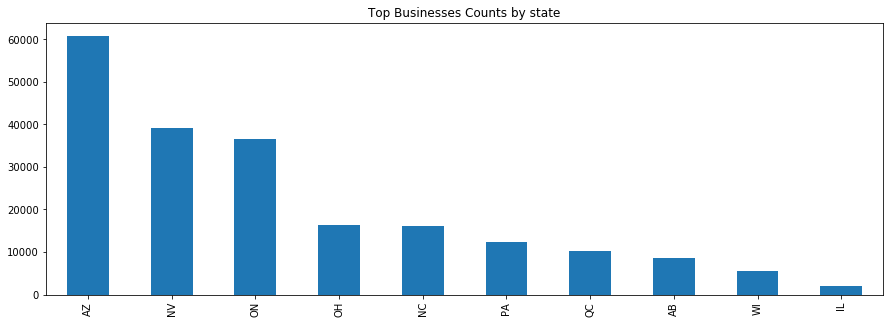

In [25]:
def plot_top(df, col):
    df[col].value_counts().head(10).plot.bar(title='Top Businesses Counts by ' + col,figsize=(15,5))
 
plot_top(df_business_final,"state")

In [26]:
df_business_filter=df_business_final.loc[df_business_final['state'].isin(["AZ", "NV"])]
df_business_filter.shape
df_business_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99887 entries, 1 to 209390
Data columns (total 74 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0_x                99887 non-null  int64  
 1   business_id                 99887 non-null  object 
 2   name                        99887 non-null  object 
 3   address                     93303 non-null  object 
 4   city                        99886 non-null  object 
 5   state                       99887 non-null  object 
 6   postal_code                 99700 non-null  object 
 7   latitude                    99887 non-null  float64
 8   longitude                   99887 non-null  float64
 9   stars                       99887 non-null  float64
 10  review_count                99887 non-null  int64  
 11  is_open                     99887 non-null  int64  
 12  attributes                  86335 non-null  object 
 13  hours                       80

# Trim Features

['attributes',
 'name',
 'address',
 'hours',
 'business_id',
 'Unnamed: 0',
 'Unnamed: 0_x',
 'Unnamed: 0_y',
 ' Restaurants',
 'longitude',
 'latitude']

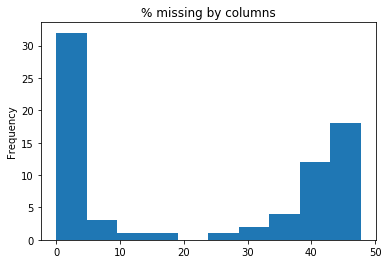

In [27]:
pd.set_option('display.max_columns', 0)

percent_missing = df_business_filter.isnull().sum() * 100 / len(df_business_final)
percent_missing.sort_values(ascending=False).plot(kind="hist", title="% missing by columns")

#Remove any columns with more than 50% missing values
missing_values_cols=percent_missing[percent_missing >50].index

#Manually Remove Values , 
remove_cols=["attributes","name","address", "hours", "business_id", "Unnamed: 0","Unnamed: 0_x","Unnamed: 0_y"," Restaurants", "longitude", "latitude"]  

drop_cols=list(missing_values_cols) + remove_cols

df_business_trim=df_business_filter.\
    assign(Restaurants=df_business_filter[' Restaurants'] + df_business_filter['Restaurants']).\
    drop(columns=drop_cols, errors="ignore").\
    rename(columns=lambda x: x.strip()) #remove whitespace from column names

drop_cols

In [28]:
encode_bool_cols=df_business_trim.select_dtypes(include='int').drop(['review_count','useful_count', 'funny_count','cool_count'], axis=1).columns
encode_bool_cols=list(encode_bool_cols)+["parking_street","BusinessAcceptsCreditCards","parking_lot"]

df_business_trim[encode_bool_cols]

,is_open,Shopping,Food,Restaurants,Home Services,Beauty & Spas,Health & Medical,Local Services,Nightlife,Bars,parking_street,BusinessAcceptsCreditCards,parking_lot
1,1,0,0,0,0,0,0,0,0,0,False,NaN,False
3,0,1,0,0,1,0,0,0,0,0,False,True,True
4,1,0,0,0,0,0,0,0,0,0,False,True,False
5,1,0,0,0,0,0,0,0,0,0,False,True,False
6,1,0,0,0,0,0,0,1,0,0,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209380,1,0,0,1,0,0,0,0,0,1,False,True,True
209382,1,0,0,0,0,0,0,0,0,0,False,NaN,False
209384,1,0,0,0,1,0,0,0,0,0,False,True,False
209386,1,0,0,0,1,0,0,1,0,0,False,True,False


## Transformation

In [29]:
def encode_null(s):
    if s=='None':
         return None
    elif pd.isnull(s):
         return None
    else:
        return s

#encode string values of null
restaurant_price_encoded=df_business_trim.RestaurantsPriceRange2.apply(encode_null).astype("float")

# #encode boolean columns 
df_boolean=df_business_trim[encode_bool_cols].applymap(encode_bool).astype('bool')

df_business_transform = df_business_trim.\
    assign(zip3=df_business_trim.postal_code.apply(lambda x:str(x)[0:3])).\
    drop("postal_code", axis=1).\
    assign(city_state=df_business_trim["city"]+"_"+df_business_trim["state"]).\
    drop("city", axis=1).\
    drop(encode_bool_cols, axis=1).\
    merge(
        df_boolean,
        how='left',
        left_index=True,
        right_index=True
    ).\
    assign(RestaurantsPriceRange2=restaurant_price_encoded)

#transform stars to categorical 0,1,2 (i.e. low,medium,high)
df_business_transform['rating_category'] = 0 #for less tha 2.5
df_business_transform.loc[(df_business_transform['stars'] > 2.5) & (df_business_transform['stars'] <= 3.9), 'rating_category'] = 1 #between 2.6 and 3.9
df_business_transform.loc[(df_business_transform['stars'] > 3.9), 'rating_category'] = 2 #greater  4 
df_business_transform['rating_category']=df_business_transform['rating_category'].astype(int) 
df_business_transform.head()

,state,stars,review_count,BikeParking,GoodForKids,ByAppointmentOnly,RestaurantsPriceRange2,DogsAllowed,WiFi,RestaurantsAttire,RestaurantsTakeOut,NoiseLevel,RestaurantsReservations,RestaurantsGoodForGroups,HasTV,Alcohol,RestaurantsDelivery,OutdoorSeating,Caters,WheelchairAccessible,AcceptsInsurance,RestaurantsTableService,Ambience,GoodForMeal,HappyHour,BusinessAcceptsBitcoin,BYOB,Corkage,GoodForDancing,CoatCheck,BestNights,Music,Smoking,DietaryRestrictions,DriveThru,HairSpecializesIn,BYOBCorkage,AgesAllowed,RestaurantsCounterService,Open24Hours,checkin_count,text,useful_count,funny_count,cool_count,review_word_count,parking_garage,parking_validated,parking_valet,zip3,city_state,is_open,Shopping,Food,Restaurants,Home Services,Beauty & Spas,Health & Medical,Local Services,Nightlife,Bars,parking_street,BusinessAcceptsCreditCards,parking_lot,rating_category
1,AZ,5.0,4,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,4,2,1,121.000000,False,False,False,852,Scottsdale_AZ,True,False,False,False,False,False,False,False,False,False,False,False,False,2
3,NV,2.5,3,True,NaN,False,4.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,1,0,0,26.666667,False,False,False,890,North Las Vegas_NV,False,True,False,False,True,False,False,False,False,False,False,True,True,0
4,AZ,4.5,26,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,11,6,3,86.962963,False,False,False,852,Mesa_AZ,True,False,False,False,False,False,False,False,False,False,False,True,False,2
5,AZ,4.5,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,4.0,25,6,2,81.690476,False,False,False,852,Gilbert_AZ,True,False,False,False,False,False,False,False,False,False,False,True,False,2
6,NV,3.5,81,True,NaN,NaN,1.0,NaN,u'no',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328.0,22.0,50,18,22,111.097561,False,False,False,891,Las Vegas_NV,True,False,False,False,False,False,False,True,False,False,False,True,True,1


In [30]:
categorical_cols=["Beauty & Spas","Bars","Nightlife","Local Services","Health & Medical","Home Services","is_open","Shopping","Food","Restaurants","BusinessAcceptsCreditCards","parking_valet","parking_lot","parking_garage","parking_street","parking_validated","RestaurantsPriceRange2","state","city_state","zip3", "rating_category"]

df_business_hot=df_business_transform
for col in categorical_cols:
    print(col)
    dummies=pd.get_dummies(df_business_hot[col], dummy_na=True, prefix=col)
    df_business_hot=df_business_hot.\
        drop(col,axis=1).\
    merge(
        dummies,
        how='left',
        left_index=True,
        right_index=True
        )

Beauty & Spas
Bars
Nightlife
Local Services
Health & Medical
Home Services
is_open
Shopping
Food
Restaurants
BusinessAcceptsCreditCards
parking_valet
parking_lot
parking_garage
parking_street
parking_validated
RestaurantsPriceRange2
state
city_state
zip3
rating_category


In [31]:
df_business_hot.head()

,stars,review_count,BikeParking,GoodForKids,ByAppointmentOnly,DogsAllowed,WiFi,RestaurantsAttire,RestaurantsTakeOut,NoiseLevel,RestaurantsReservations,RestaurantsGoodForGroups,HasTV,Alcohol,RestaurantsDelivery,OutdoorSeating,Caters,WheelchairAccessible,AcceptsInsurance,RestaurantsTableService,Ambience,GoodForMeal,HappyHour,BusinessAcceptsBitcoin,BYOB,Corkage,GoodForDancing,CoatCheck,BestNights,Music,Smoking,DietaryRestrictions,DriveThru,HairSpecializesIn,BYOBCorkage,AgesAllowed,RestaurantsCounterService,Open24Hours,checkin_count,text,...,zip3_850,zip3_851,zip3_852,zip3_853,zip3_854,zip3_855,zip3_857,zip3_858,zip3_859,zip3_860,zip3_863,zip3_864,zip3_871,zip3_880,zip3_881,zip3_889,zip3_890,zip3_891,zip3_894,zip3_895,zip3_900,zip3_910,zip3_911,zip3_912,zip3_920,zip3_925,zip3_928,zip3_930,zip3_940,zip3_952,zip3_953,zip3_959,zip3_967,zip3_981,zip3_nan,zip3_nan,rating_category_0.0,rating_category_1.0,rating_category_2.0,rating_category_nan
1,5.0,4,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2.5,3,True,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,4.5,26,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,4.5,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,4.0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
6,3.5,81,True,NaN,NaN,NaN,u'no',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328.0,22.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


# Feature Selection

In [32]:
%%time
import numpy as np
from sklearn.linear_model import LassoCV

y=df_business_hot["stars"]
X=df_business_hot.select_dtypes(include=np.number).drop(["stars","rating_category_0.0","rating_category_1.0","rating_category_2.0","rating_category_nan"],axis=1).fillna(0)

lasso = LassoCV()
lasso.fit(X, y)
coef = pd.Series(lasso.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef > 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 8 variables and eliminated the other 306 variables
CPU times: user 1min 1s, sys: 48.1 s, total: 1min 49s
Wall time: 6.72 s


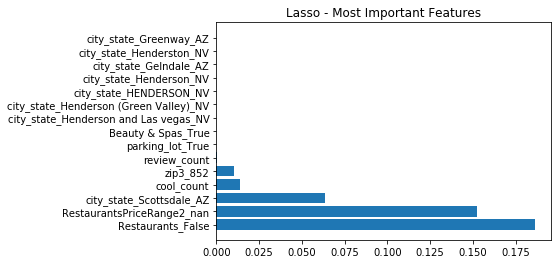

In [33]:
lasso_top_15=(coef).sort_values(ascending=False).head(15)
plt.barh(y=lasso_top_15.index, width=lasso_top_15.values)
plt.title("Lasso - Most Important Features")
plt.show()

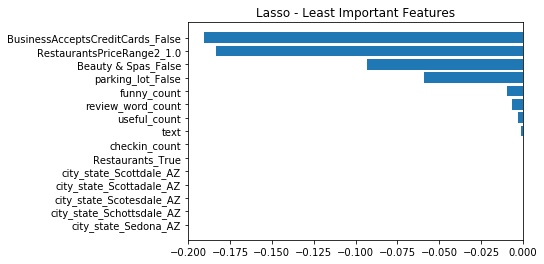

In [34]:
lasso_bottom_15=(coef).sort_values(ascending=False).tail(15)
plt.barh(y=lasso_bottom_15.index, width=lasso_bottom_15.values)
plt.title("Lasso - Least Important Features")
plt.show()

## Tree-based feature selection

In [35]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

#using the non-one hot encoded rating_category 
y2=df_business_transform["rating_category"]
X2=df_business_hot.select_dtypes(include=np.number).drop(["stars","rating_category_0.0","rating_category_1.0","rating_category_2.0","rating_category_nan"],axis=1).fillna(0)

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X2, y2)
clf.feature_importances_

coef2 = pd.Series(clf.feature_importances_, index = X2.columns)
print("Tree-based picked " + str(sum(coef2 > 0)) + " variables and eliminated the other " +  str(sum(coef2 == 0)) + " variables")

Tree-based picked 308 variables and eliminated the other 16 variables


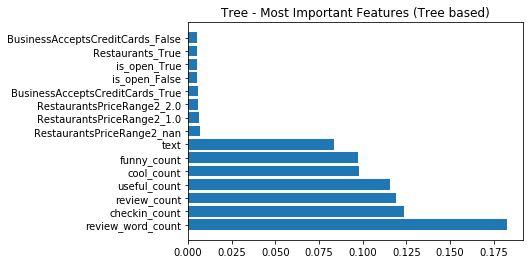

In [36]:
tree_top_15=(coef2).sort_values(ascending=False).head(15)
plt.barh(y=tree_top_15.index, width=tree_top_15.values)
plt.title("Tree - Most Important Features (Tree based)")
plt.show()

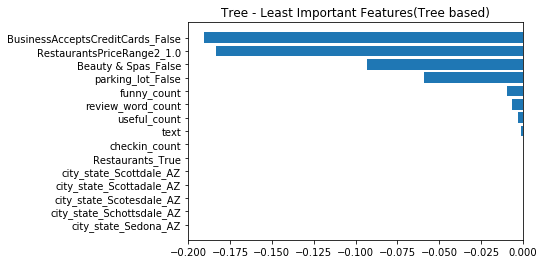

In [37]:
tree_bottom_15=(coef).sort_values(ascending=False).tail(15)
plt.barh(y=tree_bottom_15.index, width=tree_bottom_15.values)
plt.title("Tree - Least Important Features(Tree based)")
plt.show()

In [38]:
# Final Variables Selection
lasso_top_15

Restaurants_False                         1.864721e-01
RestaurantsPriceRange2_nan                1.524233e-01
city_state_Scottsdale_AZ                  6.357205e-02
cool_count                                1.377015e-02
zip3_852                                  1.017407e-02
review_count                              2.843936e-04
parking_lot_True                          1.955490e-15
Beauty & Spas_True                        1.646143e-16
city_state_Henderson and Las vegas_NV     0.000000e+00
city_state_Henderson (Green Valley)_NV   -0.000000e+00
city_state_HENDERSON_NV                   0.000000e+00
city_state_Henderson_NV                   0.000000e+00
city_state_Gelndale_AZ                   -0.000000e+00
city_state_Henderston_NV                 -0.000000e+00
city_state_Greenway_AZ                    0.000000e+00
dtype: float64

In [39]:
tree_top_15

review_word_count                   0.182641
checkin_count                       0.123458
review_count                        0.118952
useful_count                        0.115713
cool_count                          0.098106
funny_count                         0.097203
text                                0.083644
RestaurantsPriceRange2_nan          0.006844
RestaurantsPriceRange2_1.0          0.006536
RestaurantsPriceRange2_2.0          0.005928
BusinessAcceptsCreditCards_True     0.005420
is_open_False                       0.005356
is_open_True                        0.005343
Restaurants_True                    0.005068
BusinessAcceptsCreditCards_False    0.004960
dtype: float64

In [48]:
def dedup_list(x):
  return list(dict.fromkeys(x))

response_vars=["stars","rating_category"]
lasso_important_vars=["RestaurantsPriceRange2","city_state","BusinessAcceptsCreditCards","Beauty & Spas","parking_lot","review_count","zip3","cool_count","Restaurants"]
tree_important_vars=["review_word_count","checkin_count","review_count","useful_count","cool_count","funny_count","text","RestaurantsPriceRange2","Restaurants","is_open","BusinessAcceptsCreditCards"]
eda_cols=dedup_list(response_vars+lasso_important_vars+tree_important_vars)

df_business_eda=df_business_transform[eda_cols]

reorder_cols=["rating_category","stars","Beauty & Spas","BusinessAcceptsCreditCards","Restaurants","is_open","parking_lot","city_state","zip3","RestaurantsPriceRange2","text","checkin_count","useful_count","cool_count","funny_count","review_count","review_word_count"]

df_business_eda=df_business_eda.reindex(columns=reorder_cols)


# ******************************** Rubric Sections ***********************************

# 1. Business Understanding

## Purpose:  

  The data we will be using for analysis was extracted from Yelp, an online tool where users give ratings and write reviews about businesses and services on Yelp. Potential customers who are also Yelp users use the ratings and reviews to evaluate a given business or services before making a choice. This dataset was collected as part of “Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp's data and share their discoveries. In total, there are: 5,200,000 user reviews, Information on 174,000 businesses and the data spans 11 metropolitan areas[1]” 
  
## Requirements:  
  
  As a customer I want to know how my business is likely to be rated if I register it in yelp and allow customers to give feedback in the form of reviews and starts to describe their experience at my business. I also want potential customers to interact with the feedback from former customers and provide feedback on whether the reviews were useful to them.

The aim of this analysis is to determine how the customer’s choice to engage with a business or service is influenced by the ratings in yelp for a particular business. We predict that a business in a specific location and a given category, is likely to have high customer engagement based on its ratings. In other words, we are predicting that in a given business category, the number of stars the customer provides as part of feedback is determined by multiple factors such as the business location and whether or not the business does provide parking. To develop our model, we will be looking at the data for a specific business in a given location and analyze how many customers checked in and left Thank you notes. Initial inspection of the data revealed that Yelp data is in JSON format and some columns are nested which forces us to flatten the nested columns before we begin our analysis. We imported the business, checking and thank you notes JSON files and flattened them in pandas then applied the feature selection. The text on the reviews is so around 6GB so we will not include that data as there’s no use for the actual review text. We will also not be using specific customer information such as name, id as that will not be useful in our analysis.

Our response variables are stars (to indicate customer experience) and customer category rating (to indicate customers rating of the business). The stars variable is on a scale of 1 to 5 with 1 being the worst customer experience and the category rating is a categorical rating with Low, Medium and High. High indicates that this is the best restaurant there is.  

## Data Cleaning: 

We only kept business information from Arizona and Nevada because they had the highest business counts in the dataset, over half of the datasets was from these 2 states. We were only interested in restaurants so we filtered out the other business types and services. We chose to include the restaurants that have been closed because we did have very useful historical information on previous ratings and user engagement. Once we have our dataset, we will split it into separate training and test subsets then apply our algorithm on the training before using it on the test dataset.

The scenario where customer engagement prediction will be useful is during the sales process, the Yelp salesperson can use the analysis to show customers how their business rating can influence customers in the area to make a choice on whether or not they will like to engage the business.

Another scenario this will be useful is when the sales person wants to ensure that the data they are using is reliable. Our rating category will tell us how the customer rates the business with the denotion of Low, Medium or High. Let's say there's a business that's always categorized as low but the user experience rating is always a 5 (the highest available). This will be suspicious to the sales person and prompt him/her to investigate further 

## Effectiveness:

To assess predictive performance, we will randomly divide data using stratified sampling, into sets for the training data set and sets for the test data set. We will fit logistic LASSO regression using the training data set only and predict user engagement of the test data using the fitted model. The reason we will use Logistic LASSO regression is because we are predicting whether the customer will engage in the business, the outcome is denoted by Y or X. For logistic LASSO regression, we will use cross-validation to select lambda(λ). We will then calculate the misclassification error and the area under the (AUC) for test data as a way to measures the predictive performance of the fitted model. 

Note about feature selection: We also used a tree based approach  to evaluate the importance of features. The output from the tree based approach was compared to the the output from LASSO for top feature selection. 
  
 

# 2. Data Meaning Type

<font color="darkred" size="3">
                             
> The following data dictionary was prepared by the team to explain the variables included in the analysis. These features were derived from the six separate JSON files provided by Yelp to Kaggle. Each row represents an individual business with the attributes described below. The original dataset included many more variables but these are the variables deemed most important by the variable selection process.

</font> 

 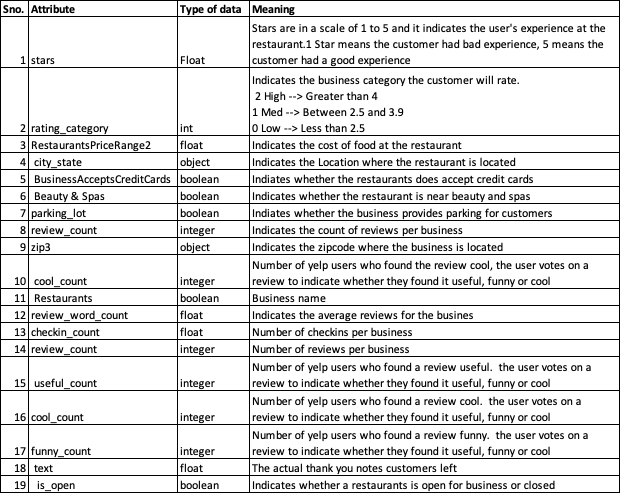

In [49]:
df_business_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99887 entries, 1 to 209390
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   rating_category             99887 non-null  int64  
 1   stars                       99887 non-null  float64
 2   Beauty & Spas               99887 non-null  bool   
 3   BusinessAcceptsCreditCards  99887 non-null  bool   
 4   Restaurants                 99887 non-null  bool   
 5   is_open                     99887 non-null  bool   
 6   parking_lot                 99887 non-null  bool   
 7   city_state                  99886 non-null  object 
 8   zip3                        99887 non-null  object 
 9   RestaurantsPriceRange2      44756 non-null  float64
 10  text                        65630 non-null  float64
 11  checkin_count               82378 non-null  float64
 12  useful_count                99887 non-null  int64  
 13  cool_count                  99

# 3. Data Quality
## Detailed steps in sections: 320 to 324 (Trim and Transform)

  
  With the dataset this big, we were expecting to see issues with data quality.  The dataset revealed that there were missing values for both categorical and continuous variables. We first deleted any columns that had more than 50% missing values.  We also dropped columns that were not relevant to our analysis, data with too many levlels such as zipcodes was kept in the dataset because we're only doing analysis for 2 states. We are aware that the address metadata which included the zipcodes  has too many levels for a machine learning model to handle and if we are to use the model on all the data set for all the states in the US, we will find a way to handle zipcodes before doing analysise. Before we did feature selection, we treated the NAs in the categorical variables as an additional category level by creating an additional column for Nans. For NAs in the continues variables, our initial focus was trying to figure out why the data was missing. Inspecting the data revealed that the data was generally randomly missing so we decided to replace the NAs with zero values. We chose not to use other imputation strategies because we did not believe that the variables we intended to use for the analysis are related to other variables in our data.   


 

<font color="darkred" size=3>

>The histogram below shows the percentage of missing values by column. This shows that many columns have no missing values. 35 columns have 10% or less missing values. However 34 columns have greater than 30% missing values. Columns with over 50% missing values were removed from the dataset. Additionally we did a check to see if any error were made that would have resulted in duplicate observations in the dataset and found there to be no duplicates.
</font> 

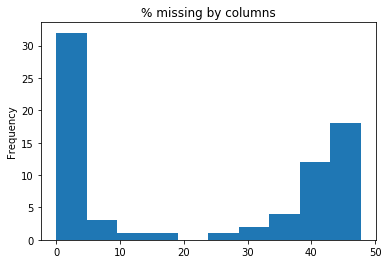

In [50]:
percent_missing = df_business_filter.isnull().sum() * 100 / len(df_business_final)
percent_missing.sort_values(ascending=False).plot(kind="hist", title="% missing by columns")

In [51]:
df_business_filter.duplicated().sum()

0

<font color='darkred' size="3">

> The logarithmic histogram plots below illustrate two of the user review related features. These are an illustration of the outliers that our found in the dataset. The general nature of the data is that most businesses do not get too many user reviews and a small number of extremely popular businesses collect the majority of the reviews. The minority of hugely popular businesses create an extreme right skew to the data. Since we have no reason to believe the data is inaccurate, we have decided to leave the outliers in there current form for the analysis.

</font>

<font color='darkred' size="3">

</font>

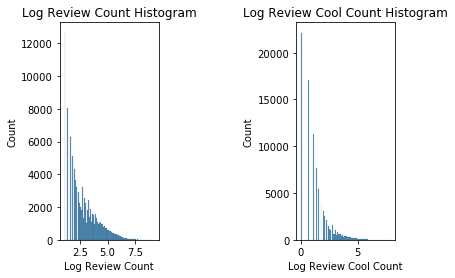

In [52]:
%matplotlib inline

plt.subplot(1, 3, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)

fig=sb.histplot(np.log(df_business_eda.review_count))
plt.xlabel("Log Review Count")
plt.ylabel("Count")
plt.title("Log Review Count Histogram") # You can comment this line out if you don't need title
plt.subplot(1,3, 3)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
fig=sb.histplot(np.log(df_business_eda.cool_count+1))
plt.xlabel("Log Review Cool Count")
plt.ylabel("Count")
plt.title("Log Review Cool Count Histogram") # You can comment this line out if you don't need title
plt.show(fig)
plt.show()

# 4. Simple Statistics

### Boolean Data


<font color='darkred'>

>The boolean features can take a value of True or False. *Beauty & Spas*, *Restaurants*, and *parking_lot* are most frequently false while *BusinessAcceptsCreditCards* and *is_open* are most frequently valued as true. There are no null or NA values. 

>80.7% of the businesses used in the analysis were currently open. In this case it implies that the business was still in business. A False value would imply that the business had permanently closed down. Despite being closed, these data were still used in the analysis as they are useful in building the classifier model. 

>26% of businesses selected that they did not accept credit cards for payment. This is slightly higher than one might have expected considering the ubiquity of credit card payments in the United States. 

>20.5% of the businesses included in the analysis are restaurants, which was the most frequent category of business in the dataset. The next business category deemed important by the feature selection process was Beauty & Spa, which 7.5% of businesses were categorized. 
    
</font>

In [53]:
df_business_eda.select_dtypes(["bool"]).describe()

,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot
count,99887,99887,99887,99887,99887
unique,2,2,2,2,2
top,False,True,False,True,False
freq,92423,73899,79423,80595,74699


In [54]:
df_business_eda.select_dtypes(["bool"]).mean().sort_values(ascending=False).mul(100).round(1).astype(str).add('%')

is_open                       80.7%
BusinessAcceptsCreditCards    74.0%
parking_lot                   25.2%
Restaurants                   20.5%
Beauty & Spas                  7.5%
dtype: object

### Numeric Data 

<font color='darkred'>
The *rating_category* has the possible values of 0,1 and 2, signifying low, medium, and high. With a mean value of 1.3, we see that over half of businesses were rated 2, while 28% received a rating of 1 and 20% received a 0 rating. As rating_category was derived from stars, the average stars exhibits a similar distribution. When looking at average stars across all businesses there is a mean value of 3.65. 
    
*RestaurantsPriceRange2* is an average price between the minimum value of 1 and a maximum value of 4. With a mean of 1.77 and 90% of the restaurants being priced at a 1 or a 2. 
    
Another noteworthy observation is the *text*, and various *_count* features are extremely right skewed. For example *check_in_count* has a median of 21, mean of 188, a standard deviation of 1065, and a maximum of 3679. These features all are aggregated from the number of user interactions with the business, either in submitting reviews, using the checkin feature, or categorizing the business as useful, cool, or funny. The interpretation would be that most businesses have few user interactions on Yelp, while a few businesses have extremely high levels of user interaction. 
    
</font>

*Original Section* 


In [55]:
df_business_eda.select_dtypes(["int", "float"]).drop("review_word_count", axis=1).describe()

,rating_category,stars,RestaurantsPriceRange2,text,checkin_count,useful_count,cool_count,funny_count,review_count
count,99887.000000,99887.000000,44756.000000,65630.000000,82378.000000,99887.000000,99887.000000,99887.000000,99887.000000
mean,1.307748,3.650035,1.774086,14.332424,188.223009,23.934646,12.825783,10.694975,51.122238
std,0.788078,1.044467,0.682658,44.659829,1065.807690,72.904120,46.841335,38.820131,166.772997
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000
25%,1.000000,3.000000,1.000000,1.000000,5.000000,2.000000,1.000000,1.000000,5.000000
50%,2.000000,4.000000,2.000000,3.000000,21.000000,6.000000,2.000000,2.000000,12.000000
75%,2.000000,4.500000,2.000000,11.000000,95.000000,19.000000,8.000000,7.000000,36.000000
max,2.000000,5.000000,4.000000,3679.000000,151671.000000,4358.000000,2599.000000,2282.000000,10129.000000


In [56]:
df_business_eda['rating_category'].value_counts(normalize=True)

2    0.511758
1    0.284231
0    0.204011
Name: rating_category, dtype: float64

In [57]:
df_business_eda['RestaurantsPriceRange2'].value_counts(normalize=True)

2.0    0.551524
1.0    0.348624
3.0    0.076995
4.0    0.022857
Name: RestaurantsPriceRange2, dtype: float64

### Categorical Data

<font color='darkred'>

For the *city_state* data there are 209 unique values. The mode value is *Las Vegas_NV* representing nearly 32% of the businesses. The next two most represented cities were Pnoenix (20% businesses) and Scottsdale(9%) Over 60% of the businesses in the dataset are in one of those three cities. 

The *zip3* variable represents the first three digits of the business zip code. In the dataset there are 50 unique values. The mode value for *zip3* is 891 (31%), which is a postal code region incorporating Las Vegas, Nevada. The next two most represented *zip3* values were 852(30%) and 850(20%). 852 and 850 both indicate being in or near Phoenix, Arizona. Over 80% of the businesses are located in 891, 852, or 850. 
</font>

In [58]:
df_business_eda.select_dtypes(["object"]).describe()

,city_state,zip3
count,99886,99887
unique,209,50
top,Las Vegas_NV,891
freq,31623,31432


In [59]:
df_business_eda["city_state"].value_counts(normalize=True)

Las Vegas_NV      0.316591
Phoenix_AZ        0.201930
Scottsdale_AZ     0.093517
Mesa_AZ           0.065845
Henderson_NV      0.052780
                    ...   
Kingman_AZ        0.000010
Glendale Az_AZ    0.000010
Redding_NV        0.000010
Hendserson_NV     0.000010
Schottsdale_AZ    0.000010
Name: city_state, Length: 209, dtype: float64

In [60]:
df_business_eda["zip3"].value_counts(normalize=True).head()

891    0.314676
852    0.297256
850    0.200587
853    0.108172
890    0.074895
Name: zip3, dtype: float64

# 5. Visualize Attributes

In [61]:
def plot_top(df, col, normalize=False):
    if(normalize):
        txt='Top Businesses Percentage by '
    else: 
        txt='Top Businesses Counts by '
    df[col].value_counts(normalize=normalize).head(10).plot.bar(title=txt + col,figsize=(15,5))

### Average Stars

<font color="darkred">
    
>The histogram below shows the distribution for businesses average stars as well as the the rating category (0-low, 1-medium, 2-high). As the rating category was derived from the average stars we are not suprised to see it follow a similar distribution. As noted in the simple statistics section, we see a median value far closer to the upper bound. Some possible explanations for why we might be seeing this phenomenon could be customer psychology. For example, a customer satisfied with a business may be more likely to review a business than a disatisfied customer. A disatisfied customer may choose to "vote with their feet", and never come back to the business. This type of behavior would not be captured in the Yelp dataset. Another possible explanation would be business manipulation. There are incentives to businesses to have a higher rating on Yelp so they may run campaigns to increase their rating. An example of this would be businesses that give a 10% discount to customers who add a review to their Yelp profile. A far less ethical example would be businesses that create fake Yelp user profiles and create positive reviews to increase their score.

</font>

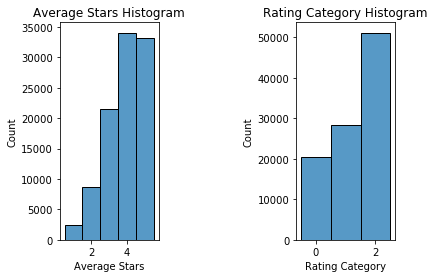

In [62]:
%matplotlib inline

plt.subplot(1, 3, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
fig=sb.histplot(df_business_eda.stars, binwidth=1,discrete=True)
plt.xlabel("Average Stars")
plt.ylabel("Count")
plt.title("Average Stars Histogram")
plt.subplot(1,3, 3)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
fig=sb.histplot(df_business_eda.rating_category, binwidth=1,discrete=True)
plt.xlabel("Rating Category")
plt.ylabel("Count")
plt.title("Rating Category Histogram")
plt.show()

### Restaurant Price Range

<font color="darkred">

> Examining the restaurant price range we find that the vast majority of restaurants fall into the 1-2 price ranges, with a small percent in the 3-4. While this just represents restaurants that are on Yelp, it seems reasonable to believe this distribution represents the actual distribution of restaurant price ranges we would see in Arizona and Nevada. A rating of 1 would indicate fast food restaurants, 2 being the most common restraunt, while high end restaurants in the 3 or 4 range are far rarer. To test whether or not there is a sampling bias we can cross-check this distribution against another data source.  

</font>

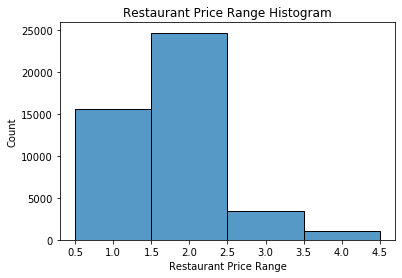

In [63]:
fig=sb.histplot(df_business_eda.RestaurantsPriceRange2, binwidth=1,discrete=True)
plt.xlabel("Restaurant Price Range")
plt.ylabel("Count")
plt.title("Restaurant Price Range Histogram")
plt.show(fig)

### Review Count 

The log histogram of *review_count* is consistent with what we see for the *cool_count*, *funny_count*, *useful_count*, *checkin_count*, *word count*, and *text* features. The data has a relatively low median value with a series of extremely high outliers skewing the plot to the upper bound. The only way to visualize this effectively is take the log value of the count data to reduce the spread. This can be interpretted to mean that while most businesses on Yelp do not get much user engagement, a small portion of the businesses get a very high level of user engagement. 

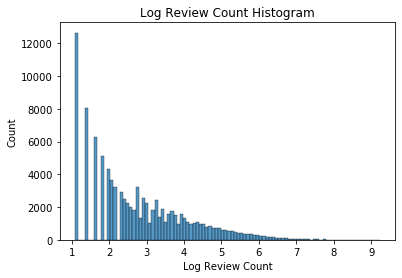

In [64]:
fig=sb.histplot(np.log(df_business_eda.review_count))
plt.xlabel("Log Review Count")
plt.ylabel("Count")
plt.title("Log Review Count Histogram") # You can comment this line out if you don't need title
plt.show(fig)

### Top Business by city_state

<font color="darkred">
    
> The cities that had the highest number of businesses were Las Vegas, Phoenix, and Scottsdale. These three cities hold more than half of the businesses represented in the data. It also is interesting to note that while Las Vegas is the city with the most businesses(30%) is from Nevada, 8 of the top 10 businesses are actually from Arizona.  
    
</font>

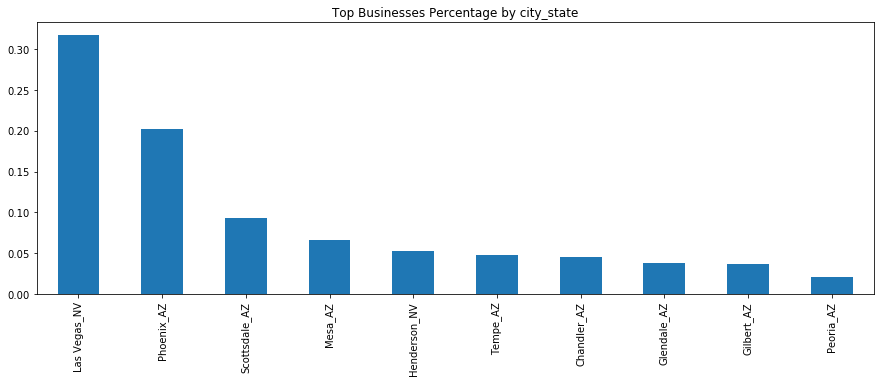

In [65]:
fig=plot_top(df_business_eda,"city_state", True)

### Categories

The original dataset included thousands of potential categories. After trimming out those infrequently used and those deemed unimportant by the Lasso and Tree-based feature selection, the *Restaurant* and *Beauty & Spas* categories remained. From the pie chart we can see that these two categories make up over 25% of the businesses in the dataset. 

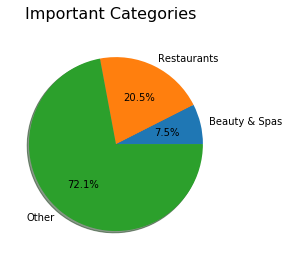

In [66]:
beauty_or_restaurants=df_business_eda["Beauty & Spas"]|df_business_eda["Restaurants"]

category_counts={
    "Beauty & Spas":(df_business_eda["Beauty & Spas"]==True).sum(),  
    "Restaurants":(df_business_eda["Restaurants"]==True).sum(),
    "Other":np.size(beauty_or_restaurants) - np.count_nonzero(beauty_or_restaurants)
}

plt.suptitle('Important Categories', fontsize=16)
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', shadow=True)
plt.show()

# 6. Explore Joint Attributes


#### Correlation Heatmap

<font color='darkred' size=3>

>The most noteable obsevation in the correlation plot is the metrics of text, checkin_count, useful_count, cool_count, funny_count,and review_count all show moderate(0.65) to strong correlation (0.97) with one another. These metrics can be generally interpretted as measures of user engagement, as it corresponds to the number of user evaluations or the average length of evaluations. The only exception to this was the average word count in each review which did not show correlation to any other variable. 
    
>One might expect to see these previously described user engagement metrics having significant correlation to the response variables of rating_cateogry or stars. However the Pearson correlation for all of these is close to zero. Future modeling will determine if they are useful in classifying the rating of a business, but these correlations  lead us away from assuming a business with higher amounts of user engagement would be more likely to have a high average rating. 
    
>There is a strong correlation (0.92) between rating_category and stars, which is to be expected as rating_category is derived from binning the stars category into the three separate categories of 0-low, 1-medium and 2-high.
    
>The only other slight correlation to be seen is between Restaurants and Parking_lot with a correlation of 0.32. This is suggesting that restaurants tend to have a parking lot more often than non-restaurants. However, while statistically significant based upon the p-value (99% confidence), 0.32 correlation is very low. No other notable correlations exist.
    
</font> 

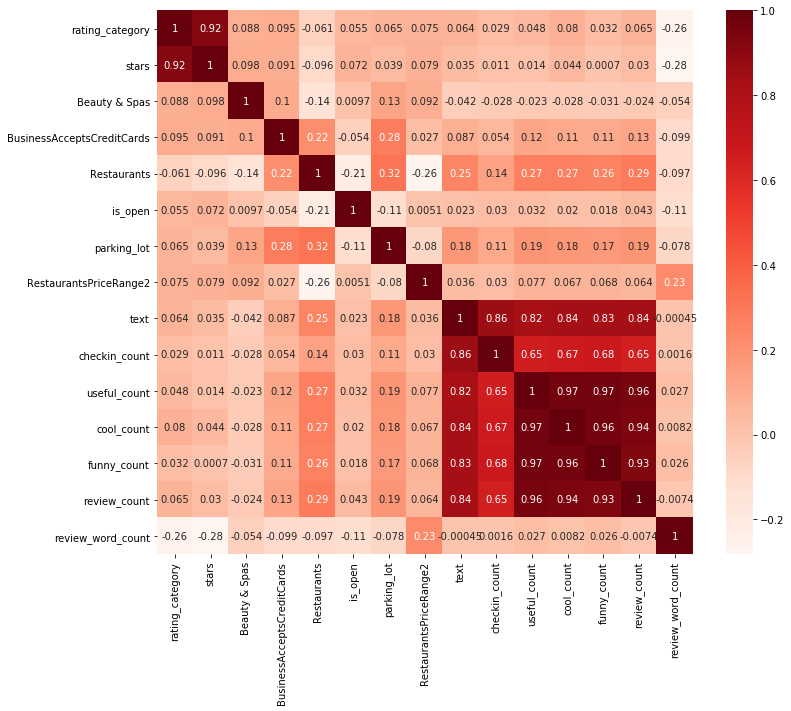

In [67]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df_business_eda.corr()
sb.heatmap(cor, annot=True, cmap=plt.cm.Reds) 
plt.show()

<font color='darkred' size=3>
    
> Of the correlations mentioned above, all were seen to be significant with a p-value indicating a 99% level of confidence. As evidenced by the second correlation plot with red cells denoted those not meeting the the 99% confidence level, the vast majority of the correlation statistics achieved high levels of confidence. This is likely due to the large number of observations in the dataset.   

</font>


In [68]:
def color_filler(series):
    confident = [1 if "***" in x else 0 for x in series]
    
    # Iterate the boolean list and based on that define CSS for each cell of the series 
    return ['background-color: white' if v else 'background-color :red;color: yellow' \
            for v in confident]

#Code for getting p-values from https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
from scipy.stats import pearsonr
import numpy as np
rho = df_business_eda.corr()
pval = df_business_eda.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
(rho.round(2).astype(str) + p).style.apply(color_filler)

,rating_category,stars,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,RestaurantsPriceRange2,text,checkin_count,useful_count,cool_count,funny_count,review_count,review_word_count
rating_category,1.0***,0.92***,0.09***,0.09***,-0.06***,0.05***,0.07***,0.07***,0.06***,0.03***,0.05***,0.08***,0.03***,0.06***,-0.26***
stars,0.92***,1.0***,0.1***,0.09***,-0.1***,0.07***,0.04***,0.08***,0.04***,0.01***,0.01***,0.04***,0.0,0.03***,-0.28***
Beauty & Spas,0.09***,0.1***,1.0***,0.1***,-0.14***,0.01***,0.13***,0.09***,-0.04***,-0.03***,-0.02***,-0.03***,-0.03***,-0.02***,-0.05***
BusinessAcceptsCreditCards,0.09***,0.09***,0.1***,1.0***,0.22***,-0.05***,0.28***,0.03***,0.09***,0.05***,0.12***,0.11***,0.11***,0.13***,-0.1***
Restaurants,-0.06***,-0.1***,-0.14***,0.22***,1.0***,-0.21***,0.32***,-0.26***,0.25***,0.14***,0.27***,0.27***,0.26***,0.29***,-0.1***
is_open,0.05***,0.07***,0.01***,-0.05***,-0.21***,1.0***,-0.11***,0.01,0.02***,0.03***,0.03***,0.02***,0.02***,0.04***,-0.11***
parking_lot,0.07***,0.04***,0.13***,0.28***,0.32***,-0.11***,1.0***,-0.08***,0.18***,0.11***,0.19***,0.18***,0.17***,0.19***,-0.08***
RestaurantsPriceRange2,0.07***,0.08***,0.09***,0.03***,-0.26***,0.01,-0.08***,1.0***,0.04***,0.03***,0.08***,0.07***,0.07***,0.06***,0.23***
text,0.06***,0.04***,-0.04***,0.09***,0.25***,0.02***,0.18***,0.04***,1.0***,0.86***,0.82***,0.84***,0.83***,0.84***,-0.0
checkin_count,0.03***,0.01***,-0.03***,0.05***,0.14***,0.03***,0.11***,0.03***,0.86***,1.0***,0.65***,0.67***,0.68***,0.65***,0.0


In [69]:
def visualize_crosstab(df, col1,col2, normalize='all'):
    ct=pd.crosstab(df[col1],
            df[col2],
            normalize = normalize 
           )
    stacked = ct.stack().reset_index().rename(columns={0:'value'})
    sb.barplot(x=stacked[col1], y=stacked.value, hue=stacked[col2])

def crosstab_heatmap(df, col1, col2, normalize='all'):
    ct=pd.crosstab(
        df[col1],
        df[col2],
        normalize=normalize).round(3)
    
    ct=ct.sort_values([col1], ascending=False)
    sb.heatmap(ct, annot=True, fmt = '.2f', cmap=sb.color_palette("light:b", as_cmap=True))

### Stars versus Review Count

<font color='darkred' size=3>

> When comparing the average stars to the review count, it is noted that businesses with 1 or 5 average ratings tend to have the fewest number of reviews. One possible conculsion to make is that as a business gets more reviews it is likely they move closer to mean value of 3.6. This is reasonable as extreme star ratings will have more ability to affect the average if there are less total reviews. 

</font>

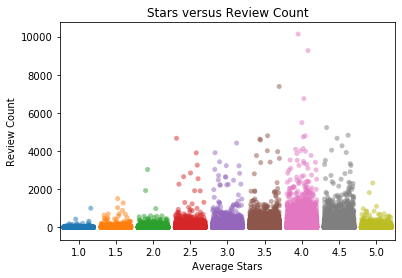

In [70]:
fig=sb.stripplot(data=df_business_eda, x="stars", y="review_count", jitter=.4, alpha=.5)

plt.xlabel("Average Stars")
plt.ylabel("Review Count")
plt.title("Stars versus Review Count")
plt.show(fig)

### Restaurant versus Review Count

<font color='darkred' size=3>
    
>Because restaurants are the most common business on Yelp, we have taken a deeper dive analyzing the differences between restaurants and other types of businesses. From the first plot below, we see that restaurants tend to receive more reviews than non-restaurants. This is unsuprising based upon the social nature of the restaurant eating experience. However when looking at the average word count of reviews, restaurants tended to have far shorter reviews than non-restaurants. It seems that while users are more likely to review a restaurant the reviews tend to be shorter in length than for non-restaurants. 
</font> 

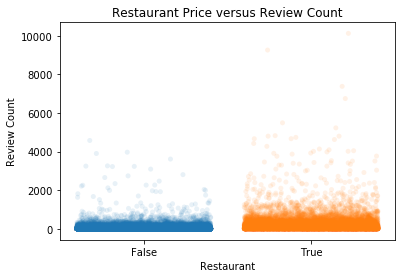

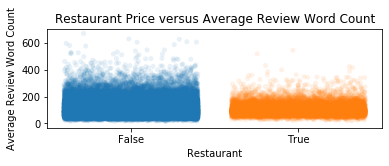

In [71]:
%matplotlib inline

plt.subplot(1, 1, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
fig=sb.stripplot(data=df_business_eda, x="Restaurants", y="review_count", jitter=.4, alpha=.1)
plt.xlabel("Restaurant")
plt.ylabel("Review Count")
plt.title("Restaurant Price versus Review Count") # You can comment this line out if you don't need title
plt.show(fig)
plt.subplot(2,1, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
fig=sb.stripplot(data=df_business_eda, x="Restaurants", y="review_word_count", jitter=.4, alpha=.1)
plt.xlabel("Restaurant")
plt.ylabel("Average Review Word Count")
plt.title("Restaurant Price versus Average Review Word Count") # You can comment this line out if you don't need title
plt.show()

### Accept Credit Cards versus Restaurants

<font color='darkred' size=3>

>While most businesses do accept credit cards, 95% of restaurants accept credit cards. 26% of the businesses represented in the dataset do not accept credit cards. Given that this variable was deemed important during the feature selection processes, further analysis should be done to determine what potential impact accepting credit cards might have on a businesses's rating. These days, with companies such as a Square, the fee to support credit card transactions is lower than ever and if it was impactful on a companies Yelp rating that would be useful information. 
    
</font>

None

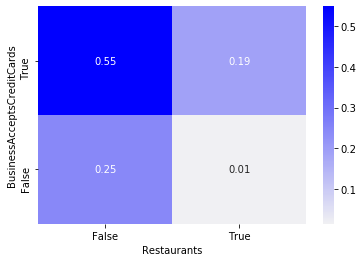

In [72]:
display(crosstab_heatmap(df_business_eda,"BusinessAcceptsCreditCards", "Restaurants"))

### Parking Lot versus Restaurants

<font color='darkred' size=3>

>The chart below shows that over 70% of businesses do not have a parking lot. However for restaurants it is nearly evenly split between having a parking lot and not having a parking lot. While non-restaurants are 6 times more likely to not have a parking lot. It's interesting that in low population density states of Nevada and Arizona to see so few businesses advertising parking lots. Since this data relies on user input, it may be worth sampling the data to find out what type of error exists in terms of businesses incorrectly classified as not having a parking lot.
    
</font> 

None

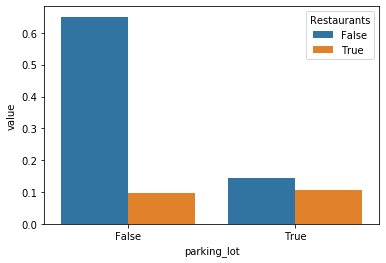

In [73]:
display(visualize_crosstab(df_business_eda,"parking_lot", "Restaurants"))

# 7. Explore Attributes and Class



### Rating Category versus Review Count

<font color='darkred' size=3>

> When comparing the rating category of business to the number of reviews the business received, there does seem to be a relationship. The highest rated category(2) shows more businesses receiving higher numbers of reviews than the medium rating(0). And the Medium rating shows shows more businesses receiving higher numbers of reviews than the low rating(0). While it is also true that regardless of rating category the majority of businesses fell below 1,000 reviews. 
>
> When comparing rating category to another user engagement metric, cool_count, we see almost the same behavior. It does see to be that as the rating category increases the user engagement metrics tend to be higher. 

</font>

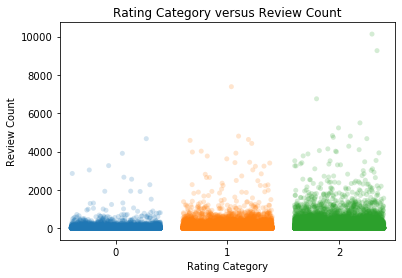

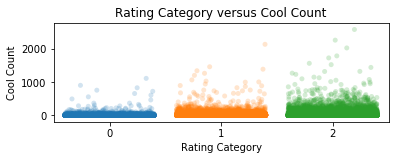

In [74]:
fig=sb.stripplot(data=df_business_eda, x="rating_category", y="review_count", jitter=.4, alpha=.2)
plt.xlabel("Rating Category")
plt.ylabel("Review Count")
plt.title("Rating Category versus Review Count") 
plt.show(fig)

%matplotlib inline

plt.subplot(1, 1, 1)  # 1 line, 2 rows, index nr 1 (first position in the subplot)
fig=sb.stripplot(data=df_business_eda, x="rating_category", y="review_count", jitter=.4, alpha=.2)
plt.xlabel("Rating Category")
plt.ylabel("Review Count")
plt.title("Rating Category versus Review Count") 
plt.subplot(2,1, 2)  # 1 line, 2 rows, index nr 2 (second position in the subplot)
fig=sb.stripplot(data=df_business_eda, x="rating_category", y="cool_count", jitter=.4, alpha=.2)
plt.xlabel("Rating Category")
plt.ylabel("Cool Count")
plt.title("Rating Category versus Cool Count") 
plt.show(fig)
plt.show()

<font color='darkred' size=3>

> When comparing the rating category of business to the average number of words in a review there is an interesting finding. It looks as though the higher the rating the lower the average word count of the reviews. While there are many outliers for each rating category the businesses that had the longest average word count of reviews were businesses rated 0. This may indicate that dissatified customers are more likely to write long Yelp reviews. 

</font>

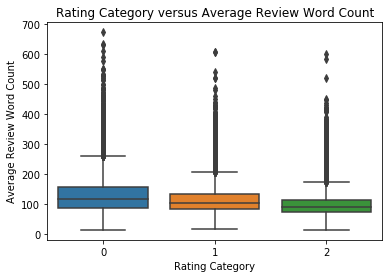

In [75]:
fig=sb.boxplot(data=df_business_eda, x="rating_category", y="review_word_count")


plt.xlabel("Rating Category")
plt.ylabel("Average Review Word Count")
plt.title("Rating Category versus Average Review Word Count") 
plt.show(fig)

<font color='darkred' size=3>

> The heatmap below shows the proportion of businesses falling into each combination of rating category and restaurant price range. It should be noted that this is only including restaurants, as non-restaurants do not have the RestaurantsPriceRange2 feature. The chart below shows us that over 50% of restaurants were in the price range 2 category. The other thing to look for is to see if there's a considerable difference of rating category distribution based upon the restaurant price range. For all price ranges we tend to have more 2 than 1 or 0 ratings, but this is due to there being the higher overall numbers of 2 rated businesses. Revisting the correlation plot above, we remember that the correlation between restaurant price range and rating category to be 0.07 which is indicative of correlation. The heatmap below confirms this. 

</font>

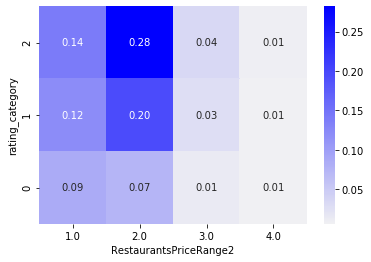

In [76]:
crosstab_heatmap(df_business_eda, "rating_category","RestaurantsPriceRange2",normalize="all")

<font color='darkred' size=3>

> It was noted about that parking_lot was selected as important to the feature selection processes. Additionally a low percentage of businesses report having parking lots than what would have been expected for Arizona and Nevada. For this reason exploring the relationship between parking_lot and rating_category is interesting. The hypothesis could be that businesses with parking lots would tend to have higher ratings. The plot below provides evideance against this hypothesis. We see nearly the exact same proportion of 2 rated businesses to 1/0 rated businesses whether the business has a parking lot or not. 
    
</font>

None

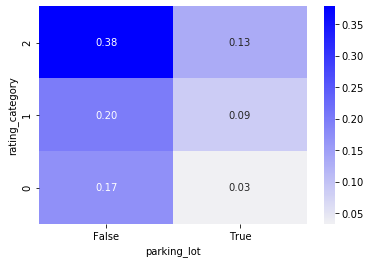

In [77]:
display(crosstab_heatmap(df_business_eda, "rating_category","parking_lot"))

# 8. New Features
## Transformation Details in section: 301

For each business we are trying to measure the enagagement based on reactions on reviews. 
Engagement Metrics:
Useful_count: Number of reviews with atleast 1 useful reaction.
funny_count: Number of reviews with atleast 1 useful funny.
cool_count: Number of reviews with atleast 1 useful cool.
review_word_count: Average word count for review by business id.

These enagagement metrics can help us understand if the overall review sentiment(rating_category) changes.

Based on the paired chart below seems like Average word count for reviews does have an impact.


In [78]:
df_review_agg.head(5)

,Unnamed: 0,business_id,useful_count,funny_count,cool_count,review_word_count
0,0,--1UhMGODdWsrMastO9DZw,9,1,11,94.103448
1,1,--6MefnULPED_I942VcFNA,40,15,16,140.859649
2,2,--7zmmkVg-IMGaXbuVd0SQ,36,27,33,94.411765
3,3,--8LPVSo5i0Oo61X01sV9A,3,0,0,88.800000
4,4,--9QQLMTbFzLJ_oT-ON3Xw,9,2,2,177.882353


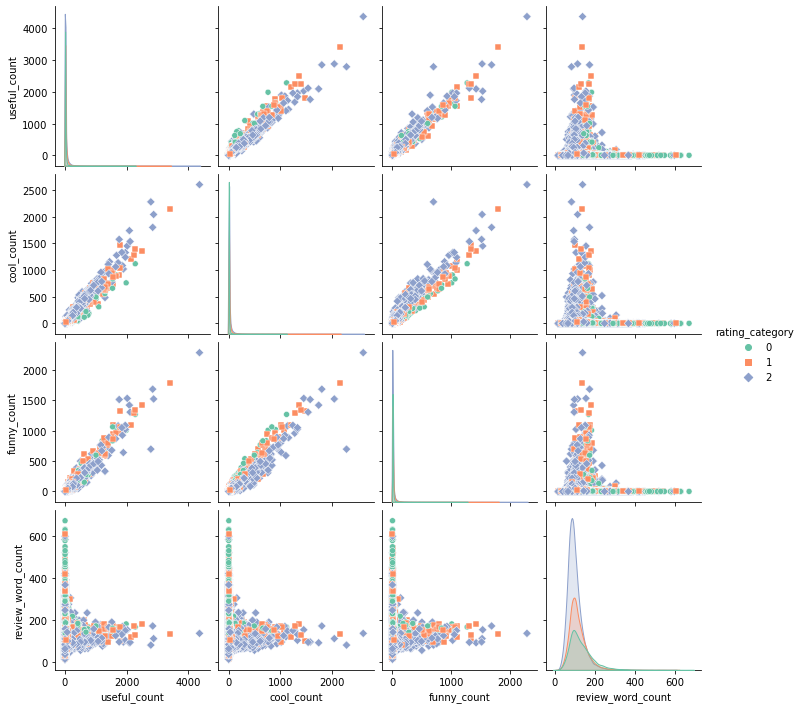

In [79]:
sb.pairplot(df_business_eda[["rating_category","useful_count","cool_count","funny_count","review_word_count"]], kind="scatter", hue="rating_category", markers=["o", "s", "D"], palette="Set2")
plt.show()

# 9. Exceptional Work

##### 1. The Yelp Datasets were highly normalized and were stored in nested dictionaries (JSON structures). A lot of work went into combining, flattening, and pivoting them out.
##### 2. Feature selection was done using two methods (Lasso and Tree-based) to narrow them down from 350+ to the final 15.
##### 3. The number of rows processed for the exercise was more than 9 million. We had to get creative in collaborating re-runs for the notebook. (example section 296,301,305)

